In [1]:
import os
import pandas

# Import sciki utilities
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Import plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

# Import math functions
import numpy as np

In [2]:
# Costants
SAMPLES_PER_RATE = 15

# Define the label to be predicted
KEY = "avg_video_rate"

In [3]:
label_mapping = {0: "LLD", 1: "LD", 2: "SD", 3: "HD", 4: "HHD"}

def get_video_quality(rate: float):
    if rate < 500:
        return 0  # Low-Low-Quality (LLD)
    elif 500 <= rate < 1000:
        return 1  # Low-Quality (LD)
    elif 1000 <= rate < 2500:
        return 2  # Standard Quality (SD)
    elif 2500 <= rate < 5000:
        return 3  # High Quality (HD)
    else:
        return 4  # High-High Quality (HHD)

In [4]:
# Define the experiment bitrates and directory paths
rates = ["1.5Mbps", "3Mbps", "4.5Mbps", "6Mbps", "7.5Mbps", "50Mbps"]
curr = os.getcwd()

# Lists to store training and testing frames
train_frames = []
test_frames  = []

train_count = {rate: 0 for rate in rates}
test_count  = {rate: 0 for rate in rates}

# Load and process data, splitting it into training and testing sets
for rate in rates:
    path = os.path.join(curr, "data", rate)

    for num, file in enumerate(os.listdir(path)):
        if num >= 20:
            break
    
        frame = pandas.read_csv(os.path.join(path, file), sep=" ")
        frame = frame[frame[KEY] > 0]
        frame[KEY] = frame[KEY].apply(get_video_quality)

        if num < SAMPLES_PER_RATE:
            train_frames.append(frame)  # Add to training set
            train_count[rate] += 1
        else:
            test_frames.append(frame)   # Add to testing set
            test_count[rate] += 1

# Combine frames into training and testing datasets
print(f"There are {len(train_frames):3d} frames in the training set")
print(f"There are {len(test_frames):3d} frames in the testing set")
for rate in rates:
    print(f"    There are {train_count[rate]:3d} of {rate} in training set")
    print(f"    There are {test_count[rate]:3d} of {rate} in testing set")
train_dataset = pandas.concat(train_frames, ignore_index=True)
test_dataset  = pandas.concat(test_frames,  ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/giorgiodaniele/Desktop/thesis/tstat-scripting/src/data/1.5Mbps'

In [286]:
# Combine training frames into a single dataset
x_train = train_dataset.drop(columns=["avg_video_rate"])
y_train = train_dataset["avg_video_rate"]

# Init the model
model = DecisionTreeClassifier(max_depth=4)
# Train the model
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [287]:
# Plot and save the decision tree as an SVG file
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=x_train.columns, rounded=True)

# Save the plot to an SVG file
plt.savefig("decision_tree.svg", format="svg")
plt.close()

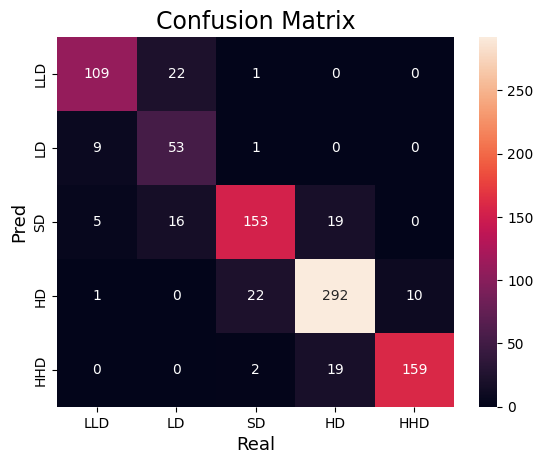

Accuracy is: 0.8577827547592385


In [288]:
# Combine test frames into a single dataset
X_test = test_dataset.drop(columns=["avg_video_rate"])
y_test = test_dataset["avg_video_rate"]

# Test the model and evaluate performance
y_pred = model.predict(X_test)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[label_mapping[i] for i in range(len(label_mapping))])

plt.ylabel("Pred",fontsize=13)
plt.xlabel("Real",fontsize=13)
plt.title("Confusion Matrix",fontsize=17)
plt.show()

# Print the accuracy
print("Accuracy is:", accuracy_score(y_test, y_pred))

In [289]:
params = {
    "max_depth": list(range(1, 11))  
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1, verbose=0)

# Fit GridSearchCV on the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model  = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 4}
Best Cross-Validated Accuracy: 0.8615148179684742
